In [1]:
# hide
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import pickle

import torch
import numpy as np

import pandas as pd


from fase import HEAAN
from fase import HEAAN as he
from typing import List, Callable

from fase import hnrf as hnrf

from fase.hnrf.tree import NeuralTreeMaker
from fase.hnrf import heaan_nrf 
from fase.hnrf.hetree_nrf import HomomorphicModel 

#import importlib

In [3]:
def decrypt_print(ctx, n=20):
    res1 = decrypt(secretKey, ctx)
    print(res1[:n])
    
def decrypt(secretKey, enc):
    featurized = scheme.decrypt(secretKey, enc)
    arr = np.zeros(n, dtype=np.complex128)
    featurized.__getarr__(arr)
    return arr.real

def encrypt(val):
    ctxt = HEAAN.Ciphertext()#logp, logq, n)
    vv = np.zeros(n) # Need to initialize to zero or will cause "unbound"
    vv[:len(val)] = val
    scheme.encrypt(ctxt, he.Double(vv), n, logp, logq)
    del vv
    return ctxt

# Adult income dataset

Here we wll study the Adult Income Dataset and see how we can apply Homomorphic Random Forest to it.

## Data loading

In [4]:
from sklearn.model_selection import train_test_split

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None)

df.columns = [
    "Age", "WorkClass", "fnlwgt", "Education", "EducationNum",
    "MaritalStatus", "Occupation", "Relationship", "Race", "Gender",
    "CapitalGain", "CapitalLoss", "HoursPerWeek", "NativeCountry", "Income"
]

# df = df.sample(frac=0.1, random_state=1)
train_cols = df.columns[0:-1]
label = df.columns[-1]
X = df[train_cols]
y = df[label].apply(lambda x: 0 if x == " <=50K" else 1) #Turning response into 0 and 1

seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

## Data preprocessing

Because we need our data to be in the range$[-1,1]$ at the beginning, we will create a preprocessing pipeline using sklearn Pipelines. 

It will apply a LabelEncoder on categorical columns, before using it in a MinMaxScaler.

In [5]:
from fase.hnrf.preprocessing import Featurizer #임시로.. 

categorical_columns = ["WorkClass","Education","MaritalStatus", "Occupation", "Relationship", 
                       "Race", "Gender", "NativeCountry"]

pipe = Featurizer(categorical_columns)

X_train_normalized = pipe.fit_transform(X_train)

In [6]:
X_train_normalized.min()

0.0

We can have a look and check that input is in $[-1,1]$.

## Neural Random Forest

Now that data has been preprocessed, we can feed it to a Neural Random Forest.

Here we can have a look at the activation function we will use, for instance sigmoid.

In [7]:
from fase.hnrf.tree import NeuralRF#, SigmoidTreeMaker, TanhTreeMaker
#from cryptotree.polynomials import plot_graph_function_approximation

max_depth = 6

dilatation_factor = 10
polynomial_degree = 10

#plot_graph_function_approximation(torch.sigmoid,
#                                  dilatation_factor=dilatation_factor,polynomial_degree=polynomial_degree)

In [8]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=max_depth, random_state=0)
rf.fit(X_train_normalized, y_train)

RandomForestClassifier(max_depth=6, random_state=0)

### Without finetuning

crytotree에서는 서로 다른 크기/깊이의 tree를 가장 큰 tree에 맞춰 pad함.  (tree.py: L220)
왜..? 

In [8]:
#from cryptotree.RFconvertor import gen_l1, gen_l2
#estimators = rf.estimators_

In [9]:
from fase.hnrf.tree import NeuralTreeMaker
from sklearn.tree import BaseDecisionTree
#from functools import partial

#from cryptotree.tree import *
#from cryptotree.RFconvertor import *

estimators = rf.estimators_

my_tm_tanh = NeuralTreeMaker(torch.tanh, 
                            use_polynomial=True,
                            dilatation_factor=dilatation_factor, 
                            polynomial_degree=polynomial_degree)

#my_tanh_rf =NeuralRF(estimators[:2], my_tm_tanh)

model =NeuralRF(estimators[:5], my_tm_tanh)

In [13]:
dt = estimators[0]

In [15]:
print("Number of features == ", X_train.shape[1])
print("Number of questions == ", )

Number of features ==  14
Number of questions == 


In [16]:
model.comparator.shape

torch.Size([14, 57, 5])

In [17]:
# comparator가 어떻게 생겼는지... 
model.comparator[:,:,0]

tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.

In [18]:
import matplotlib.pyplot as plt 

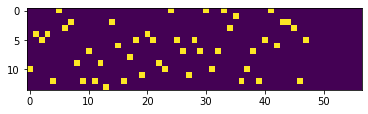

In [19]:
plt.imshow(model.comparator.data[:,:,0].cpu().numpy())

### Sigmoid 트리는 성능이 매우 떨어짐. tanh는 얼추 비슷

In [10]:
with torch.no_grad():
    #sigmoid_neural_pred = sigmoid_neural_rf(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()
    #tanh_neural_pred = tanh_neural_rf(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()
    #tanh_neural_pred = my_tanh_rf(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()
    tanh_neural_pred = model(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()
    
pred = rf.predict(X_train_normalized)
print(f"Original accuracy : {(pred == y_train).mean()}")

#print(f"Accuracy of sigmoid  : {(sigmoid_neural_pred == y_train).mean()}")
print(f"Accuracy of tanh : {(tanh_neural_pred == y_train).mean()}")

#print(f"Match between sigmoid and original : {(sigmoid_neural_pred == pred).mean()}")
print(f"Match between tanh and original : {(tanh_neural_pred == pred).mean()}")

Original accuracy : 0.855497542997543
Accuracy of tanh : 0.7560657248157249
Match between tanh and original : 0.8433660933660934


We can see that there is a discrepancy between the original Random Forest and the neural ones, especially for the sigmoid one.

Nonetheless we can correct this error by finetuning the final layer of our neural networks to take into account the fact that due to using activation functions not sharp enough.

### With finetuning

Because we need to make sure that at each step of the Neural Network the output is in $[-1,1]$, to be able to use the polynomial approximation of the activation, we can only safely train the last layer.

Here we first define our Pytorch Dataset.

In [11]:
from torch.utils import data
import numpy as np

class TabularDataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, X: np.ndarray, y: np.ndarray):
        'Initialization'
        self.X, self.y = X,y

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

    def __getitem__(self, index):
        'Generates one sample of data'

        # Load data and get label
        X = torch.tensor(self.X[index]).float()
        y = torch.tensor(self.y[index])

        return X, y

Then we split our training data into training and validation.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)
X_train_normalized, X_valid_normalized, y_train, y_valid = train_test_split(pipe.transform(X_train), 
                                                                            y_train,
                                                                            train_size=0.8)

Then we create the Pytorch dataloaders.

In [17]:
train_ds = TabularDataset(X_train_normalized, y_train.values)
valid_ds = TabularDataset(X_valid_normalized, y_valid.values)

bs = 128

train_dl = data.DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = data.DataLoader(valid_ds, batch_size=bs)
fix_dl = data.DataLoader(train_ds, batch_size=bs, shuffle=False)

Here we will just define the model, which is a sigmoid Neural Random Forest.

#tree_maker = tanh_tree_maker

model =NeuralRF(rf.estimators_, tree_maker=my_tm_tanh)
model.to("cpu")

Because we only want to train the last layer, we will freeze the first two layers and check they are frozen.

In [18]:
model.freeze_layer("comparator")
model.freeze_layer("matcher")

for p in model.parameters():
    print(p.shape, p.requires_grad)

torch.Size([14, 57, 5]) False
torch.Size([57, 5]) False
torch.Size([58, 57, 5]) False
torch.Size([58, 5]) False
torch.Size([2, 58, 5]) True
torch.Size([2, 5]) True


In [19]:
pred = rf.predict(X_train_normalized)

with torch.no_grad():
    neural_pred = model(torch.tensor(X_train_normalized).float()).argmax(dim=1).numpy()

print(f"Original accuracy : {(pred == y_train).mean()}")
print(f"Accuracy : {(neural_pred == y_train).mean()}")
print(f"Same output : {(neural_pred == pred).mean()}")

Original accuracy : 0.8568480660332085
Accuracy : 0.7562146079278241
Same output : 0.8418754199059411


Now we can define our fastai Learner, with the dataset, the model, and the loss function, which is a Label Smoothing Cross Entropy here.

In [20]:
import fastai
fastai.__version__
# Need Fastai 1, NOT 2

'1.0.61'

In [21]:
from fastai.basic_data import DataBunch
from fastai.tabular.learner import Learner
from fastai.metrics import accuracy

from fase.hnrf.tree import CrossEntropyLabelSmoothing
import torch.nn as nn

data = DataBunch(train_dl, valid_dl,fix_dl=fix_dl)

criterion = CrossEntropyLabelSmoothing()

learn = Learner(data, model, loss_func=criterion, metrics=accuracy)

We will use fastai lr finder to have an idea of what learning rate to choose.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


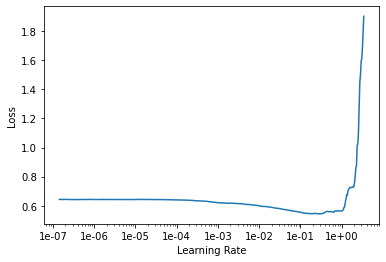

In [22]:
learn.lr_find(num_it=500)
learn.recorder.plot()

Here we can see that a good learning rate should be around 1e-1.

We can now fine tune our model.

In [23]:
learn.fit_one_cycle(5,1e-1 / 2)

epoch,train_loss,valid_loss,accuracy,time
0,0.533845,0.518835,0.813052,00:00
1,0.505172,0.504718,0.828791,00:00
2,0.500321,0.499961,0.834549,00:00
3,0.496484,0.498958,0.838580,00:00
4,0.496100,0.498154,0.835317,00:00


Here we can have a look at the performance of the Neural Random Forest tuned with respect to the original sklearn Random Forest.

In [27]:
pred = rf.predict(X_valid_normalized)

with torch.no_grad():
    neural_pred = model(torch.tensor(X_valid_normalized).float()).argmax(dim=1).numpy()

print(f"Original accuracy : {(pred == y_valid).mean()}")
print(f"Accuracy : {(neural_pred == y_valid).mean()}")
print(f"Same output : {(neural_pred == pred).mean()}")

Original accuracy : 0.8581573896353167
Accuracy : 0.8483685220729367
Same output : 0.9641074856046066


## Homomorphic Random Forest

Now that we have seen how a Neural Random Forest can be obtained and fine tuned from a regular sklearn Random Forest, we can now see how its Homomorphic Random Forest counterpart performs.

To do so, we must first initialize the parameters of the CKKS SEAL library, and choose the polynomial activation function we want. Here we will use the same activation function as the above Neural Random Forest.

In [28]:
class Param():
    def __init__(self, n=None, logn=None, logp=None, logq=None, logQboot=None):
        self.n = n
        self.logn = logn
        self.logp = logp
        self.logq = logq 
        self.logQboot = logQboot
        if self.logn == None:
            self.logn = int(np.log2(n))

In [29]:
logq = 540
logp = 30
logn = 14
n = 1*2**logn

parms = Param(n=n, logp=logp, logq=logq)

do_reduction=False
Nclass = 2

ring = HEAAN.Ring()
secretKey = HEAAN.SecretKey(ring)
scheme = HEAAN.Scheme(secretKey, ring)# isSerialized=True로 하면 에러남. 

algo = HEAAN.SchemeAlgo(scheme)


# reduction때는 right rotation N_class개 필요. 
if do_reduction:
    scheme.addLeftRotKeys(secretKey)
    for i in range(Nclass):
        scheme.addRightRotKey(secretKey, i+1) # 
else:
    # reduction 안 하면 하나짜리 rotation만 여러번 반복.
    scheme.addLeftRotKey(secretKey, 1)

In [30]:
from fase.hnrf.cryptotree import HomomorphicNeuralRandomForest
h_rf = HomomorphicNeuralRandomForest(model)

In [31]:
import importlib
importlib.reload(heaan_nrf)

featurizer = heaan_nrf.HomomorphicTreeFeaturizer(h_rf.return_comparator(), scheme, parms)

nrf_evaluator = heaan_nrf.HomomorphicTreeEvaluator.from_model(h_rf,
                                                    scheme,
                                                    parms,
                                                    my_tm_tanh.coeffs,
                                                    do_reduction = do_reduction
                                                    )

nrf_evaluator.sk = secretKey

CKKS paramters:
---------------------------
n = 16384
logp = 30
logq = 540
tanh activation polynomial coeffs = [-9.638754e-16  4.758149e+00  8.250976e-14 -1.838215e+01 -7.910440e-13  3.860479e+01  2.454118e-12 -3.728043e+01
 -3.008826e-12  1.331208e+01  1.268642e-12]
tanh activation polynomial degree = 10

Neural RF
---------------------------



In [32]:
x = X_valid_normalized[0]

ctx = featurizer.encrypt(x)
#decrypt_print(ctx)

result = nrf_evaluator(ctx)

In [33]:
out1 = nrf_evaluator.decrypt(result[1])

In [34]:
np.sum(out1)

-0.23402404785156253

In [35]:
np.sum(out0)

NameError: name 'out0' is not defined

In [ ]:
homomophic_pred = decrypt(secretKey, result)
np.argmax(homomophic_pred[:Nclass])
print(homomophic_pred[:5])

decrypt_print(nrf_evaluator.w1_ctx[0])

In [ ]:
ctx.logq

In [ ]:
temp = nrf_evaluator.compare(ctx)

#Compare OK

decrypt_print(temp)

#temp2 = nrf_evaluator.match(temp)

output = nrf_evaluator._mat_mult(nrf_evaluator.w1_ctx, temp)

#scheme.encrypt(b1_ctx, self.b1_hedb, n, logp, output.logq)
print(f"MATCH:: 'output.logq', {output.logq} == {nrf_evaluator.b1_ctx.logq}?")

decrypt_print(output)

nrf_evaluator.scheme.addAndEqual(output, nrf_evaluator.b1_ctx)

decrypt_print(output)

temp2 = nrf_evaluator.activation(output)

decrypt_print(temp2)

temp3 = nrf_evaluator.decide(temp2)

decrypt_print(temp3[1])

In [ ]:
final = nrf_evaluator.reduce(temp3)

일단 reduce는 안 하는 걸로..

In [ ]:
homomophic_pred[:100]

In [ ]:
temp3[0].n

In [ ]:
HEAAN.Ciphertext()

We can see what was the original output, if we had used only the Neural Random Forest : 

In [ ]:
x = X_train_normalized[i]

pred = rf.predict_proba(x.reshape(1,-1))
neural_pred = model(torch.tensor(x).float().unsqueeze(0))

print(f"Original Random Forest output : {pred}")
print(f"Neural Random Forest output : {neural_pred.detach()}")
print(f"Homomorphic Random Forest output : {homomorphic_pred}")

Here we can see our Neural Random Forest, and Homomorphic Random Forest have very similar outputs.

## Comparison between models

We will now compare a linear model, a RF, a NRF and a HRF. 

Because computation are done one at a time with HRF, we will use Fastai `parallel` to speedup inference taking advantage of the multiple CPUs.

In [ ]:
from fastai.core import parallel
import multiprocessing

def predict(x, index):
    """Performs HRF prediction"""
    
    # We first encrypt and evaluate our model on it
    ctx = homomorphic_featurizer.encrypt(x)
    outputs = tree_evaluator(ctx)
    
    # We then decrypt it and get the first 2 values which are the classes scores
    # ptx = seal.Plaintext()
    ptx = decryptor.decrypt(outputs)
    
    homomorphic_pred = encoder.decode(ptx)[:2]
    homomorphic_pred = np.argmax(homomorphic_pred)
    
    return index, homomorphic_pred

# We get the number of cores
cores = multiprocessing.cpu_count()

n_example = 320

# We compute the outputs
hrf_pred = parallel(predict, X_valid_normalized[:n_example,:], max_workers=cores)

# Because the outputs are unordered we must first sort by index then take the predictions
hrf_pred = np.array(sorted(hrf_pred, key = lambda x:x[0]))[:,1]

We compute the predictions of the NRF.

In [ ]:
outputs = []

for x,y in valid_dl:
    with torch.no_grad():
        pred = model(x)
    outputs.append(pred)
    
nrf_pred = torch.cat(outputs).argmax(dim=1).numpy()

Finally we compute the predictions of logistic regression and RF.

In [ ]:
from sklearn.linear_model import LogisticRegression

linear = LogisticRegression()
linear.fit(X_train_normalized, y_train)

# We compute the linear preds
linear_pred = linear.predict(X_valid_normalized)

# We compute the random forest predictions
rf_pred = rf.predict(X_valid_normalized)

We can compute all metrics now.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred, y):
    """Computes all the metrics between predictions and real values"""
    accuracy = accuracy_score(pred,y)
    precision = precision_score(pred,y)
    recall = recall_score(pred,y)
    f1 = f1_score(pred, y)
    return dict(accuracy=accuracy, precision=precision, recall=recall, f1=f1)

models = dict(nrf=nrf_pred, hrf=hrf_pred, rf=rf_pred, linear=linear_pred)

outputs = []
for name, pred in models.items():
    metrics = compute_metrics(pred[:n_example], y_valid[:n_example])
    metrics["model"] = name
    outputs.append(metrics)

In [ ]:
outputs = pd.DataFrame(outputs)

outputs

In [ ]:
outputs.to_csv("results.csv", index = None)

Finally we can have a look at how similar NRF and HRF predictions are.

In [ ]:
nrf_pred.shape

In [ ]:
hrf_pred

In [ ]:
nrf_pred == hrf_pred

In [ ]:
np.sum(nrf_pred == hrf_pred)

In [ ]:
np.sum(nrf_pred == hrf_pred)/len(hrf_pred)

## Exporting featurizer and models

We will now see how we can export the model and the featurizer for the server and the client.

The preprocessing pipeline can be saved for later use on the client side. We can save and load it with pickle.

In [ ]:
import pickle

pickle.dump(pipe, open("pipe.pkl", "wb"))
pipe = pickle.load(open("pipe.pkl" , "rb"))

We can also store as well the featurizer, used to shuffle the features before the comparisons. This will be sent to the client side to prepare the data before sending it.

In [ ]:
homomorphic_featurizer.save("homomorphic_featurizer.pkl")

Finally, we can store the Homomorphic Random Forest to use on the server side.

In [ ]:
pickle.dump(h_rf, open("h_rf.pkl", "wb"))

For the demo built using Streamlit, we need to know what were the values of the categorical features, and also one example of values.

In [ ]:
for col in X_train.columns.values:
    if col in categorical_columns:
        X_train[col] = X_train[col].astype("category")
    else:
        X_train[col] = X_train[col].astype(np.float32)

In [ ]:
example = X_train.iloc[[0]]
example.to_csv("example.csv", index=None)

In [ ]:
dtypes = X_train.dtypes
pickle.dump(dtypes, open("dtypes.pkl", "wb"))

In [ ]:
dtypes = pickle.load(open("dtypes.pkl", "rb"))
dtypes

In [ ]:
torch.save(model.state_dict(), "model.pkl")